# Quick analysis of Ting's data using nelpy

### Dataset description

I am using a small subset of data from "Hippocampal awake replay in fear memory retrieval" by Chun-Ting Wu, Daniel Haggerty, Caleb Kemere, and Daoyun Ji. Paper here: http://www.nature.com/neuro/journal/vaop/ncurrent/pdf/nn.4507.pdf

In this notebook, I only load data from day 1, before any of the shock trials or anything like that. The animal runs on a 2.25 m linear track, one half of which is dark, and the seconds half of which is light. Without any modification, the animals prefer to stay in the dark, of course.

### Imports

In [1]:
import scipy.io # used to load .mat file
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sys import float_info

import nelpy as nel
import nelpy.plotting as npl

import warnings

from nelpy import hmmutils
from nelpy.utils import rmse
from nelpy.decoding import decode1D as decode

%matplotlib inline

warnings.filterwarnings("ignore")

### Load .mat file

In [2]:
mat = scipy.io.loadmat("simplified (Newton, 2015-03-11_15-09-22).mat", squeeze_me=True)
# mat = scipy.io.loadmat("simplified (Maxwell, 2015-01-15_10-50-59).mat", squeeze_me=True)

eeg = mat['eeg']
try:
    eeg_timestamp = mat['eegtimestamp']
except KeyError:
    eeg_timestamp = mat['eeg_timestamp']
pos_track1 = mat['pos_track1']
pos_track2 = mat['pos_track2']
spike_track1 = mat['spike_track1']
spike_track2 = mat['spike_track2']
pos_timestamp_track1 = mat['pos_timestamp_track1']
pos_timestamp_track2 = mat['pos_timestamp_track2']
try:
    pos_track3 = mat['pos_track3']
    spike_track3 = mat['spike_track3']
    pos_timestamp_track3 = mat['pos_timestamp_track3']
except KeyError:
    pass

del mat

FS = 10000

### Create AnalogSignalArray for LFP

In [3]:
step = np.diff(eeg_timestamp)[0]

lfp = nel.AnalogSignalArray(eeg, tdata=eeg_timestamp, step=step)
lfp._support = lfp._support.merge(gap=0.01)
lfp._fs = 1.0/np.diff(lfp.time[:100]).mean() # this is a temporary fix, because we're still patching up some things with AnalogSignalArray.fs

print(lfp)

<AnalogSignalArray at 0x1f291e5f7f0: 1 signals (4 segments)> for a total of 46:24:597 minutes


In [4]:
lfp.n_samples

5,665,280

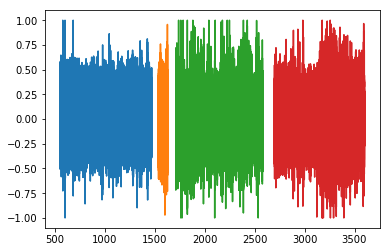

In [5]:
npl.plot(lfp);

In [6]:
[print(segment.n_samples) for segment in lfp];

1,864,192
187,904
1,778,688
1,834,496


### Create SpikeTrainArrays

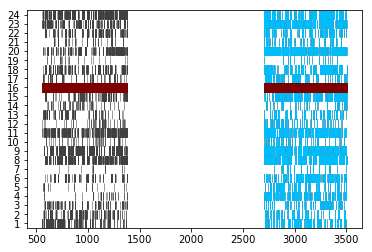

In [7]:
st1 = nel.SpikeTrainArray(spike_track1, fs=1)  # still need to determine start of spike train support
first_spk = np.min([st[0] for st in st1.time if len(st) !=0]) - 0.05
last_spk = np.min([st[-1:] for st in st1.time]) + 0.05
st1 = nel.SpikeTrainArray(spike_track1, support=nel.EpochArray([first_spk, last_spk], fs=1), fs=1)

st2 = nel.SpikeTrainArray(spike_track2, fs=1)  # still need to determine start of spike train support
first_spk = np.min([st[0] for st in st2.time if len(st) !=0]) - 0.05
last_spk = np.min([st[-1:] for st in st2.time]) + 0.05
st2 = nel.SpikeTrainArray(spike_track2, support=nel.EpochArray([first_spk, last_spk], fs=1), fs=1)

# join spike trains into one object, just for convenience later on
st = nel.utils.spiketrain_union(st1, st2)

ax = npl.rasterplot(st, lw=0.5)
npl.rasterplot(st2, ax=ax, color='deepskyblue', lw=0.5)

# highlight unsorted spikes on raster:
unsorted_unit_id = np.argmax(st.n_spikes) + 1
npl.rasterplot(st._unit_subset([unsorted_unit_id]), color='maroon', lw=0.5)

In [8]:
firing_rates = st.n_spikes / st.support.duration
firing_rates # in Hz

array([  0.93945354,   1.17400992,   0.45744633,   0.4789371 ,
         0.39972827,   0.86884102,   0.04543762,   2.52547217,
         1.91390634,   0.09947155,   1.79969826,   0.14613722,
         0.35429065,   0.0896472 ,   0.97445279,  28.50965193,
         0.34692239,   1.10155533,   0.03991143,   1.5375109 ,
         0.15227744,   0.74419457,   0.90875245,   2.44319323])

### Create AnalogSignalArrays for position

In [9]:
pos_scaling = 3.1 # cm per pixel
camera_fs = 33 # camera (position) acquisition rate was 33 Hz

# fix up some missing data
for idx in np.where(np.isnan(pos_track1))[0]:
    pos_track1[idx] = np.nanmean(pos_track1[idx-10:idx+10])

for idx in np.where(np.isnan(pos_track2))[0]:
    pos_track2[idx] = np.nanmean(pos_track2[idx-10:idx+10])

# create nelpy objects containing the trajectories
pos = nel.AnalogSignalArray(np.append(pos_track1, pos_track2)/pos_scaling, tdata=np.append(pos_timestamp_track1, pos_timestamp_track2)/FS)
pos1 = nel.AnalogSignalArray(pos_track1/pos_scaling, tdata=pos_timestamp_track1/FS) # in cm?
pos2 = nel.AnalogSignalArray(pos_track2/pos_scaling, tdata=pos_timestamp_track2/FS) # in cm?

# set position fs explicitly, since this is not yet handled well in nelpy.AnalogSignalArray
pos._fs = pos1._fs = pos2._fs = camera_fs

# fix supports
pos._support = pos._support.merge(gap=0.05)
pos1._support = pos1._support.merge(gap=0.05)
pos2._support = pos2._support.merge(gap=0.05)

### Smooth position estimates

In [10]:
# smooth position estimates, with default 50 ms standard deviation
pos = nel.utils.smooth_AnalogSignalArray(pos)
pos1 = nel.utils.smooth_AnalogSignalArray(pos1)
pos2 = nel.utils.smooth_AnalogSignalArray(pos2)

### Estimate running speed

animal ran an average of 14.16 cm/s on the entire track, sampled at approx 33.0 Hz
animal ran an average of 15.77 cm/s on track 1, sampled at approx 33.0 Hz
animal ran an average of 12.52 cm/s on track 2, sampled at approx 33.0 Hz


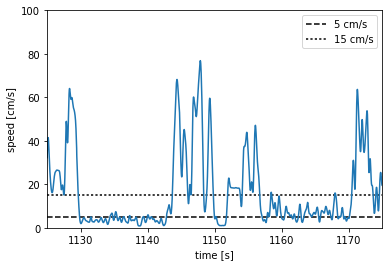

In [11]:
sigma_100ms = 0.1
speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_100ms)
speed1 = nel.utils.dxdt_AnalogSignalArray(pos1, smooth=True, sigma=sigma_100ms)
speed2 = nel.utils.dxdt_AnalogSignalArray(pos2, smooth=True, sigma=sigma_100ms)

print('animal ran an average of {:1.2f} cm/s on the entire track, sampled at approx {:2.1f} Hz'.format(speed.mean(), speed.fs))
print('animal ran an average of {:1.2f} cm/s on track 1, sampled at approx {:2.1f} Hz'.format(speed1.mean(), speed.fs))
print('animal ran an average of {:1.2f} cm/s on track 2, sampled at approx {:2.1f} Hz'.format(speed2.mean(), speed.fs))

stat_thresh = 5 # stationary threshold in cm/s
ax = npl.plot(speed1)
ax.set_xlim(1125,1175)
ax.set_ylim(0,100)
ax.set_xlabel('time [s]')
ax.set_ylabel('speed [cm/s]')
ax.hlines(stat_thresh, *ax.get_xlim(), linestyle='--', label='{} cm/s'.format(stat_thresh))
ax.hlines(3*stat_thresh, *ax.get_xlim(), linestyle=':', label='{} cm/s'.format(3*stat_thresh))
ax.legend()

### Compute periods of RUN and immobility

In [12]:
run_epochs1 = nel.utils.get_run_epochs(speed1)
run_epochs2 = nel.utils.get_run_epochs(speed2)

inactive_epochs1 = nel.utils.get_inactive_epochs(speed1)
inactive_epochs2 = nel.utils.get_inactive_epochs(speed2)

# display quick summary of run and inactive events
print("running track 1: ", run_epochs1)
print("inactive track 1:", inactive_epochs1)

print("running track 2: ", run_epochs2)
print("inactive track 2:", inactive_epochs2)

running track 1:  <EpochArray at 0x1f29a752278: 365 epochs> of duration 9:22:637 minutes
inactive track 1: <EpochArray at 0x1f29a752630: 260 epochs> of duration 4:00:575 minutes
running track 2:  <EpochArray at 0x1f29a0ba358: 372 epochs> of duration 7:23:924 minutes
inactive track 2: <EpochArray at 0x1f29a0ba7f0: 326 epochs> of duration 5:22:678 minutes


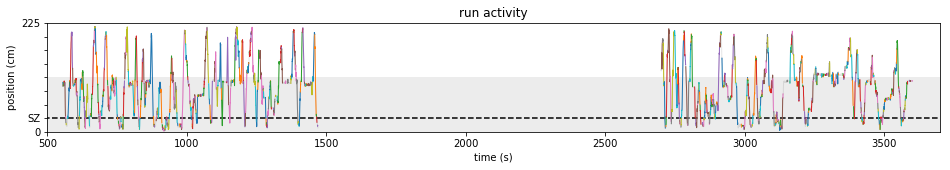

In [13]:
fig = plt.figure(figsize=(16,2))
ax = fig.add_subplot(111)

plt.plot(pos1.tdata, pos1.asarray().yvals, lw=1, alpha=0.2, color='gray')
plt.plot(pos2.tdata, pos2.asarray().yvals, lw=1, alpha=0.2, color='gray')
npl.plot(pos1[run_epochs1], ax=ax, lw=1, label='run track 1')
npl.plot(pos2[run_epochs2], ax=ax, lw=1, label='run track 2')

ax.add_patch(patches.Rectangle((0, 0),   # (x,y)
                width=4000 ,          # width
                height=225/2,          # height
                facecolor='gray',
                edgecolor='none',
                alpha=0.15,
            ))
ax.hlines(225/8, 0, 4000, linestyle='--')
ax.set_xlabel('time (s)')
ax.set_ylabel('position (cm)')
ax.set_ylim(0,225)
ax.set_yticks(np.linspace(0,225,9))
ax.set_yticklabels([0,'SZ','','','','','','',225])
ax.set_xlim(500,3700)

plt.title('run activity')

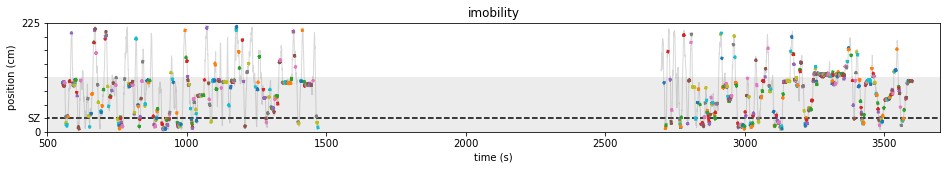

In [14]:
fig = plt.figure(figsize=(16,2))
ax = fig.add_subplot(111)

plt.plot(pos1.tdata, pos1.asarray().yvals, lw=1, alpha=0.3, color='gray')
plt.plot(pos2.tdata, pos2.asarray().yvals, lw=1, alpha=0.3, color='gray')
npl.plot(pos1[inactive_epochs1], lw=3, ax=ax, label='inactive track 1')
npl.plot(pos2[inactive_epochs2], lw=3, ax=ax, label='inactive track 2')

ax.add_patch(patches.Rectangle((0, 0),   # (x,y)
                width=4000 ,          # width
                height=225/2,          # height
                facecolor='gray',
                edgecolor='none',
                alpha=0.15,
            ))
ax.hlines(225/8, 0, 4000, linestyle='--')
ax.set_xlabel('time (s)')
ax.set_ylabel('position (cm)')
ax.set_ylim(0,225)
ax.set_yticks(np.linspace(0,225,9))
ax.set_yticklabels([0,'SZ','','','','','','',225])
ax.set_xlim(500,3700)

plt.title('imobility')

### MUA event detection

In [15]:
def get_mua(st):
    # collapse spike trains across all units
    mua_spks = st.flatten(unit_label='mua')

    # bin spikes into 1 ms bins, so that we can smooth the spike times
    ds_1ms = 0.001  # bin width of 1 ms
    mua_binned = mua_spks.bin(ds=ds_1ms)

    # smooth MUA spike train (this is our estimated mua firing 'rate')
    sigma = 0.010 / ds_1ms # 10 ms standard deviation
    bw = 6 # bandwidth of filter (outside of this bandwidth, the filter is zero)
    smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(np.squeeze(mua_binned.data.astype(float)), 
                                                              sigma=sigma, truncate=bw)

    # store MUA firing 'rate' in an AnalogSignalArray
    mua = nel.AnalogSignalArray(smoothed_spikes/ds_1ms, tdata=mua_binned.bin_centers, step=ds_1ms) # in Hz
    
    return mua

mua = get_mua(st)

In [16]:
print([seg.mean() for seg in mua])
print(mua.mean())

[42.30735438527987, 53.952180065032856]
48.05085078791213


In [17]:
def get_mua_events(mua, mua_ds=0.001):
    # determine MUA event bounds:
    mua_bounds_idx, maxes, _ = nel.utils.get_events_boundaries(
        x = mua.ydata,
        PrimaryThreshold = mua.mean() + 3*mua.std(),
        SecondaryThreshold = mua.mean(),
        minThresholdLength = 0.015, # 10 ms PrimaryThreshold crossing requirement
        minLength = 0.07, # 70 ms minimum event duration
        maxLength = 1.5,  # 1500 ms maximum event duration
        ds = mua_ds
    )

    if len(mua_bounds_idx) == 0:
        raise ValueError("no mua events detected")

    # store MUA bounds in an EpochArray
    mua_epochs = nel.EpochArray(mua.time[mua_bounds_idx], fs=1)
    
    return mua_epochs

mua_epochs = get_mua_events(mua)
mua_epochs1 = get_mua_events(mua[0])
mua_epochs2 = get_mua_events(mua[1])
print('mua epochs (combined sessions) BEFORE speed restriction:', mua_epochs)
print('mua epochs on track1 BEFORE speed restriction:', mua_epochs1)
print('mua epochs on track2 BEFORE speed restriction:', mua_epochs2)

mua epochs (combined sessions) BEFORE speed restriction: <EpochArray at 0x1f29aa35208: 516 epochs> of duration 1:26:429 minutes
mua epochs on track1 BEFORE speed restriction: <EpochArray at 0x1f29a0c8be0: 258 epochs> of duration 49.649 seconds
mua epochs on track2 BEFORE speed restriction: <EpochArray at 0x1f29c8822b0: 251 epochs> of duration 38.44 seconds


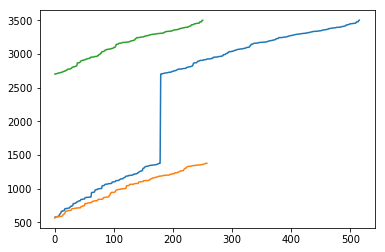

In [18]:
plt.plot(mua_epochs.centers)
plt.plot(mua_epochs1.centers)
plt.plot(mua_epochs2.centers)

**Remark:** As expected, if we determine MUA events based on the combined MUA, then the second track will have more events, and the first track will have fewer events, compared to when we do MUA event detection separately for the two tracks.

In [19]:
def restrict_mua_by_speed(mua_epochs,*, v, inactve_epochs=None, speed=None):
    """
    Parameters
    ----------
    v : float
        minimum average running speed (in cm/s) for mua event
    
    Returns
    -------
    
    """
    # APPROACH 1: restrict MUA events to where the animal was running less than x units/sec
    if inactve_epochs is not None:
        assert speed is None, "cannot provide both speed and inactive epochs!"
        mua_epochs = mua_epochs[inactive_epochs]
        return mua_epochs

    # APPROACH 2: to calculating periods of inactivity: compute average speed during each mua event:
    # create new AnalogSignalArray containing speed, so that we can find events during immobility
    assert speed is not None and v is not None, "must provide either inactive_epochs or speed"
    
    avg_speeds = np.array([event.mean() for event in speed[mua_epochs]])
    mua_idx, = np.where(avg_speeds < v)
    mua_epochs_speedB = mua_epochs[mua_idx]

    # set mua_epochs equal to speed restricted mua events
    mua_epochs = mua_epochs_speedB
    
    # merge mua events that are close together
    mua_epochs = mua_epochs.merge(gap=0.05) # join events separated by only 50 ms
    
    return mua_epochs

v = 5 # speed, presumably in cm/s
mua_epochs1sr = restrict_mua_by_speed(mua_epochs1, speed=speed1, v=v) # should ideally be 3 cm/s
mua_epochs2sr = restrict_mua_by_speed(mua_epochs2, speed=speed2, v=v) # should ideally be 3 cm/s
print("mua epochs on track 1:", mua_epochs1sr)
print("mua epochs on track 2:", mua_epochs2sr)

mua epochs on track 1: <EpochArray at 0x1f29c60ff98: 39 epochs> of duration 4.717 seconds
mua epochs on track 2: <EpochArray at 0x1f29c60feb8: 66 epochs> of duration 9.339 seconds


### Expand mua epochs

In [20]:
# expand epochs by 20 ms on either side
# _20ms = 0.02 # 20 ms
# mua_epochs1sr = mua_epochs1sr.expand(_20ms)
# mua_epochs2sr = mua_epochs2sr.expand(_20ms)

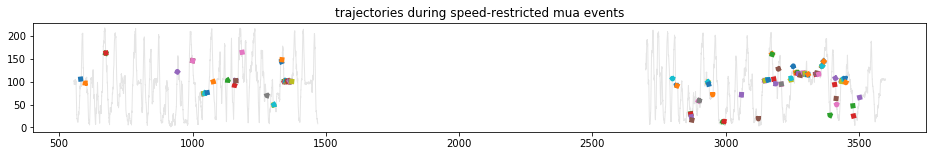

In [21]:
fig = plt.figure(figsize=(16,2))
ax = fig.add_subplot(111)

plt.plot(pos1.tdata, pos1.asarray().yvals, lw=1, alpha=0.2, color='gray')
plt.plot(pos2.tdata, pos2.asarray().yvals, lw=1, alpha=0.2, color='gray')
npl.plot(pos1[mua_epochs1sr], ax=ax, label='inactive track 1', lw=5)
npl.plot(pos2[mua_epochs2sr], ax=ax, label='inactive track 2', lw=5)

plt.title('trajectories during speed-restricted mua events')

### Estimate tuning curves from RUN data

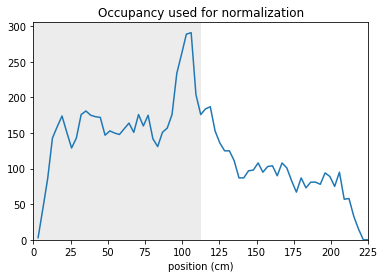

In [22]:
ds_run = 0.1 # 100 ms
st_run = st[run_epochs1.join(run_epochs2)]

# now remove unit corresponding to unsorted spikes
# unsorted_unit_id = np.argmax(st.n_spikes)
# all_but_unsorted = np.delete(np.arange(st.n_units), unsorted_unit_id) + 1
# st_run = st_run._unit_subset(all_but_unsorted)

bst_run = st_run._bin(ds=ds_run, ds_prime=ds_run*100, w=20)

bst = bst_run

xpos = pos.interp(bst.bin_centers).squeeze()

# compute occupancy
n_xbins = 70
xmin = 0  # cm
xmax = 225 # cm
occupancy, bins = np.histogram(xpos, bins=n_xbins, range=(xmin,xmax)); 
pos_bin_idx = np.digitize(xpos, bins)
xbins = (bins + xmax/n_xbins)[:-1]

ratemap = np.zeros((bst.n_units, n_xbins))
for tt, bidx in enumerate(pos_bin_idx):
    ratemap[:,bidx-1] += bst.data[:,tt]
    
# normalize spike counts by occupancy:
denom = np.tile(occupancy, (bst.n_units,1))
denom[denom==0] = 1

# ratemap = ratemap / denom
ratemap = ratemap / denom / bst.ds
ratemap[ratemap < 0.001] = 0.001

ax = plt.gca()
ax.plot(xbins, occupancy)
ax.set_title('Occupancy used for normalization')
ax.set_xlabel('position (cm)')
ax.set_xlim(0,225)
ax.set_ylim(0)

ax.add_patch(patches.Rectangle((0, 0),   # (x,y)
                width=225/2 ,          # width
                height=ax.get_ylim()[1],          # height
                facecolor='gray',
                edgecolor='none',
                alpha=0.15,
            ))

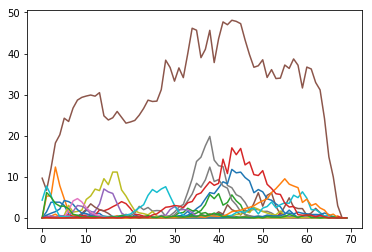

In [23]:
plt.plot(ratemap.T);

In [24]:
import scipy.ndimage.filters
sigma = 6.2 / (xmax/n_xbins) # 6.2 cm standard deviation
bw = 4 # bandwidth of filter (outside of this bandwidth, the filter is zero)
smoothed_rate = scipy.ndimage.filters.gaussian_filter(np.squeeze(ratemap), sigma=(0,sigma), truncate=bw)


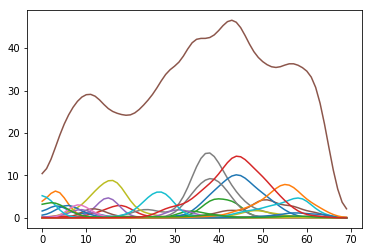

In [25]:
plt.plot(smoothed_rate.T);

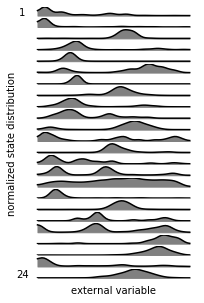

In [26]:
npl._plot_tuning_curves1D(smoothed_rate, sharey=False);

In [27]:
def reorder_ratemap(ratemap, neworder):
    """Reorder units according to a specified order.

        neworder must be list-like, of size (n_units,)
    """
    newratemap = ratemap.copy()
    oldorder = list(range(len(neworder)))
    for oi, ni in enumerate(neworder):
        frm = oldorder.index(ni)
        to = oi
        nel.utils.swap_rows(newratemap, frm, to)
        oldorder[frm], oldorder[to] = oldorder[to], oldorder[frm]
    
    return newratemap

In [28]:
def get_peak_firing_order_on_track1D(ratemap):
    """Docstring goes here
    
    ratemap has shape (n_units, n_ext)
    """
    peakorder = np.argmax(ratemap, axis=1).argsort()
    
    return peakorder

peakorder = get_peak_firing_order_on_track1D(smoothed_rate)
newratemap = reorder_ratemap(smoothed_rate, peakorder)

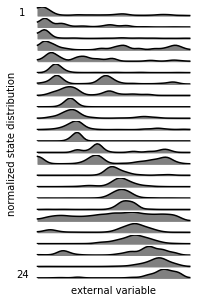

In [29]:
npl._plot_tuning_curves1D(newratemap, sharey=False);

In [30]:
# now reorder actual spike train, as well as ratemap that we use for decoding below:
st.reorder_units(peakorder)
st1.reorder_units(peakorder)
st2.reorder_units(peakorder)
smoothed_rate = reorder_ratemap(smoothed_rate, peakorder)


### Decode RUN data to verify that decoder works

In [37]:
# bin into 0.2 second bins; smooth spikes over equivalent of 2 seconds (here, 50 x 40 ms bins)
ds_run=0.2

runspks = st[run_epochs1.join(run_epochs2)]

# now remove unit corresponding to unsorted spikes
# unsorted_unit_id = np.argmax(st.n_spikes)
# all_but_unsorted = np.delete(np.arange(st.n_units), unsorted_unit_id) + 1
# runspks = runspks._unit_subset(all_but_unsorted)

bst = runspks._bin(ds=ds_run, ds_prime=2, w=35)

In [38]:
# decode neural activity
posterior, _, mode_pth, mean_pth = decode(bst, smoothed_rate, xmax=225)

rmse: 25.4545794246 35.9806274706


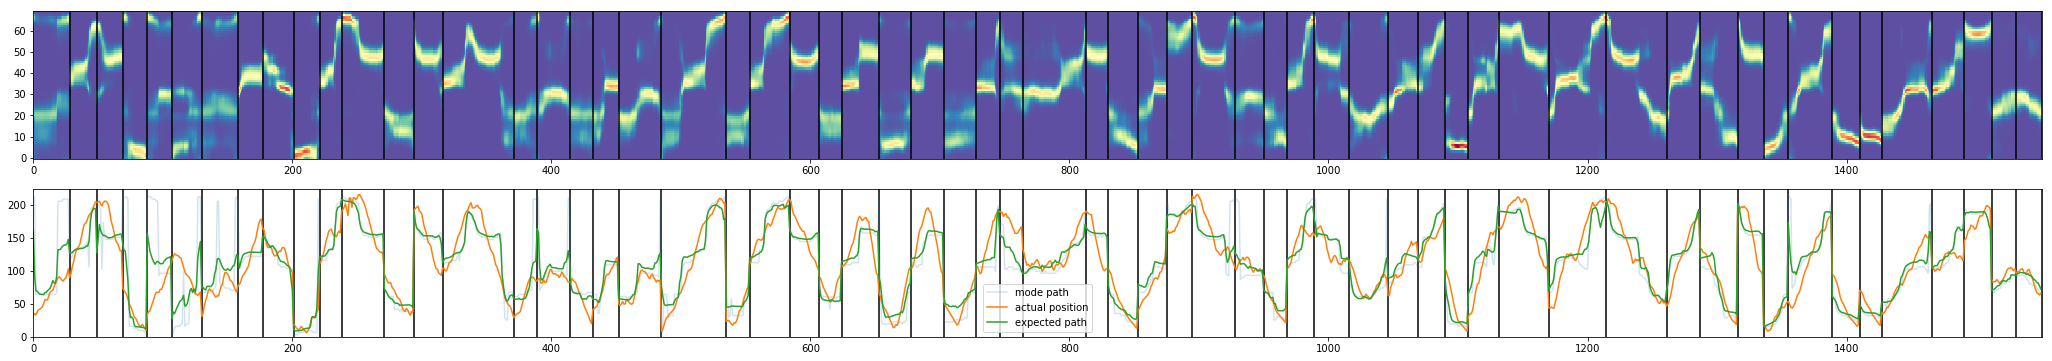

In [39]:
xpos = pos.interp(bst.bin_centers).squeeze()

fig = plt.figure(figsize=(36,6))
ax0 = fig.add_subplot(211)

npl.imagesc(posterior, cmap=plt.cm.Spectral_r, ax=ax0)
ax0.vlines(np.cumsum(bst.lengths), *ax0.get_ylim())

ax1 = fig.add_subplot(212)
ax1.plot(mode_pth, label='mode path', alpha=0.2)
ax1.plot(xpos, label='actual position')
ax1.plot( mean_pth, label='expected path')
ax1.vlines(np.cumsum(bst.lengths), *ax1.get_ylim())
ax1.set_ylim(0,225)

ax1.legend()

axes=[ax0, ax1]

for ax in axes:
    ax.set_xlim(0, bst.lengths.sum())
    
print('rmse:', rmse(mean_pth, xpos), rmse(mode_pth, xpos))

### MUA event decoding

In [34]:
# effectively smooth spikes over 30 ms
ds_20ms = 0.02

muaspks = st[mua_epochs1sr.join(mua_epochs2sr)]

# now remove unit corresponding to unsorted spikes
# unsorted_unit_id = np.argmax(st.n_spikes)
# all_but_unsorted = np.delete(np.arange(st.n_units), unsorted_unit_id) + 1
# muaspks = muaspks._unit_subset(all_but_unsorted)

bst = muaspks._bin(ds=ds_20ms, ds_prime=2, w=3)

# decode neural activity
posterior, _, mode_pth, mean_pth = decode(bst, smoothed_rate, xmax=225)

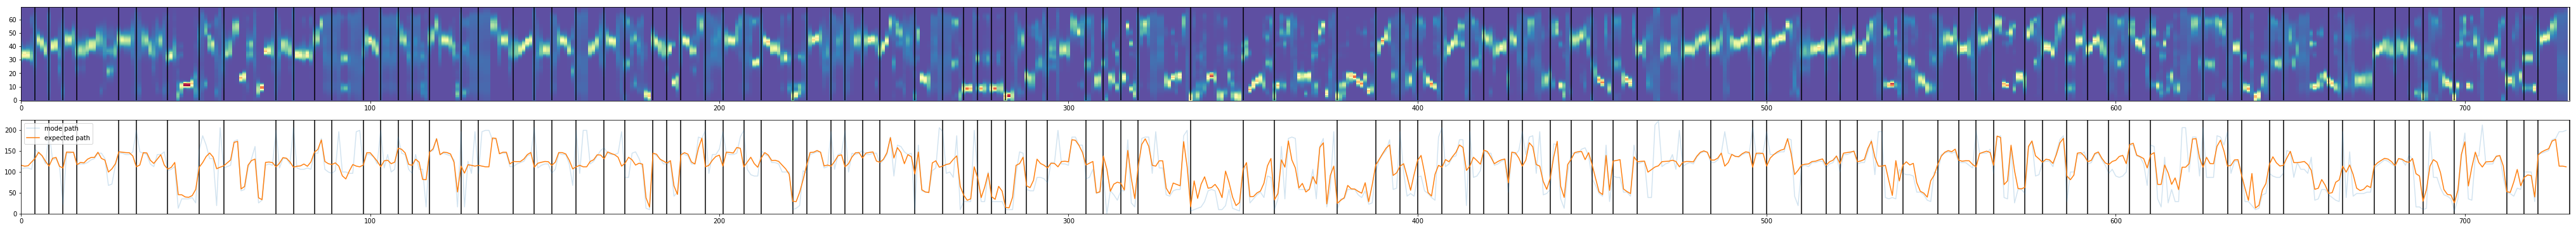

In [35]:
fig = plt.figure(figsize=(72,6))

ax0 = fig.add_subplot(211)
ax0.vlines(np.cumsum(bst.lengths), xmin, xmax)

npl.imagesc(posterior, cmap=plt.cm.Spectral_r)

ax1 = fig.add_subplot(212)
ax1.plot(mode_pth, label='mode path', alpha=0.2)
ax1.plot(mean_pth, label='expected path')
ax1.set_ylim(xmin,xmax)
ax1.vlines(np.cumsum(bst.lengths), *ax1.get_ylim())

ax1.legend()

axes=[ax0, ax1]

for ax in axes:
    ax.set_xlim([0,bst.lengths.sum()])


### Decode MUA events with different window sizes and step sizes:

Below I decode with 20 ms bins, but in the first it is advanced in 10 ms steps, while in the second case it is advanced in 5 ms steps, and finally in 1 ms steps.

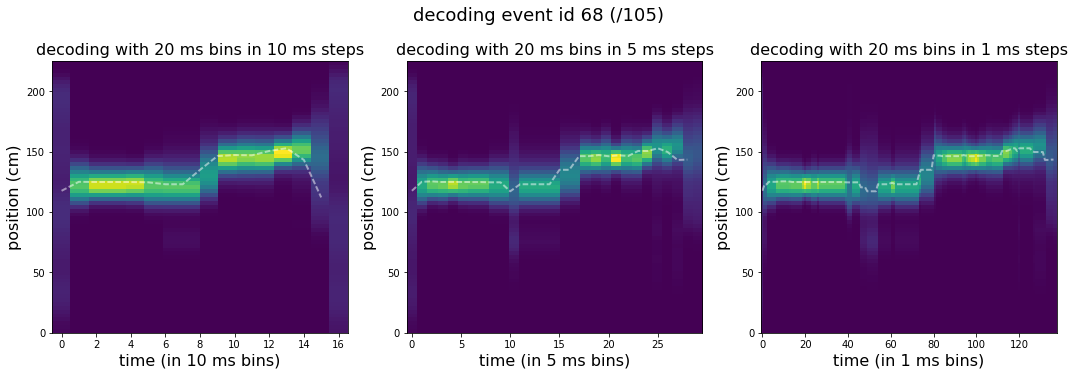

In [36]:
muaspks = st[mua_epochs1sr.join(mua_epochs2sr)]

# decode neural activity
fig = plt.figure(figsize=(18,5))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

event_id = 69 #12 # 34 # 41

ds_10ms = 0.01
bst = muaspks._bin(ds=ds_10ms) # no spike smoothing this time
posteriors, bdries, mode_pth, mean_pth = decode(bst, smoothed_rate, w=2, xmax=225)
npl.imagesc(y=np.linspace(0,225,1000), x=np.linspace(0,len(mode_pth[bdries[event_id]:bdries[event_id+1]]),len(mode_pth[bdries[event_id]:bdries[event_id+1]])), data=posteriors[:,bdries[event_id]:bdries[event_id+1]], cmap=plt.cm.viridis, ax=ax0)
ax0.plot(mean_pth[bdries[event_id]:bdries[event_id+1]], color='w', lw=2, linestyle='--', alpha=0.5)
ax0.axis('tight')
ax0.set_title('decoding with 20 ms bins in 10 ms steps', fontsize=16)
ax0.set_xlabel('time (in 10 ms bins)', fontsize=16)
ax0.set_ylabel('position (cm)', fontsize=16)

ds_5ms = 0.005
bst = muaspks._bin(ds=ds_5ms) # no spike smoothing this time
posteriors, bdries, mode_pth, mean_pth = decode(bst, smoothed_rate, w=4, xmax=225)
npl.imagesc(y=np.linspace(0,225,1000), x=np.linspace(0,len(mode_pth[bdries[event_id]:bdries[event_id+1]]),len(mode_pth[bdries[event_id]:bdries[event_id+1]])), data=posteriors[:,bdries[event_id]:bdries[event_id+1]], cmap=plt.cm.viridis, ax=ax1)
ax1.plot(mean_pth[bdries[event_id]:bdries[event_id+1]], color='w', lw=2, linestyle='--', alpha=0.5)
ax1.axis('tight')
ax1.set_title('decoding with 20 ms bins in 5 ms steps', fontsize=16)
ax1.set_xlabel('time (in 5 ms bins)', fontsize=16)
ax1.set_ylabel('position (cm)', fontsize=16)

ds_1ms = 0.001
bst = muaspks._bin(ds=ds_1ms) # no spike smoothing this time
posteriors, bdries, mode_pth, mean_pth = decode(bst, smoothed_rate, w=20, xmax=225)
npl.imagesc(y=np.linspace(0,225,1000), x=np.linspace(0,len(mode_pth[bdries[event_id]:bdries[event_id+1]]),len(mode_pth[bdries[event_id]:bdries[event_id+1]])), data=posteriors[:,bdries[event_id]:bdries[event_id+1]], cmap=plt.cm.viridis, ax=ax2)
ax2.plot(mean_pth[bdries[event_id]:bdries[event_id+1]], color='w', lw=2, linestyle='--', alpha=0.5)
ax2.axis('tight')
ax2.set_title('decoding with 20 ms bins in 1 ms steps', fontsize=16)
ax2.set_xlabel('time (in 1 ms bins)', fontsize=16)
ax2.set_ylabel('position (cm)', fontsize=16)

fig.suptitle('decoding event id {} (/{})'.format(event_id-1, bst.n_epochs), fontsize=18, y=1.03)

# Uncurated content below this line

In [118]:
def collapse_time(obj):
    """Collapse all epochs in a SpikeTrainArray and collapse them into a single, contiguous SpikeTrainArray"""
    
    # We'll have to ajust all the spikes per epoch... and we'll have to compute a new support. Also set a flag!
    
    # If it's a SpikeTrainArray, then we left-shift the spike times. If it's an AnalogSignalArray, then we
    # left-shift the time and tdata.
    
    # Also set a new attribute, with the boundaries in seconds.
    
    if isinstance(obj, nel.AnalogSignalArray):
        pass
    elif isinstance(obj, nel.SpikeTrainArray):
        new_obj = nel.SpikeTrainArray(empty=True)
        new_time = lists = [[] for _ in range(obj.n_units)]
        duration = 0
        for st_ in obj:
            le = st_.support.start
            for unit_ in range(obj.n_units):
                new_time[unit_].extend(st_._time[unit_] - le + duration)
            duration += st_.support.duration
        new_time = np.asanyarray([np.asanyarray(unittime) for unittime in new_time])
        new_obj._time = new_time
        new_obj._support = nel.EpochArray([0, duration], fs=1)
        new_obj._unit_ids = obj._unit_ids         
        new_obj._unit_labels = obj._unit_labels
    elif isinstance(obj, nel.BinnedSpikeTrainArray):
        raise NotImplementedError("BinnedSpikeTrains are not yet supported, but bst.data is essentially already collapsed!")
    else:
        raise TypeError("unsupported type for collapse_time")
   
    return new_obj

In [119]:
collapse_time(muaspks).support

<EpochArray at 0x7fc114571390: 1 epoch> of duration 14.056 seconds

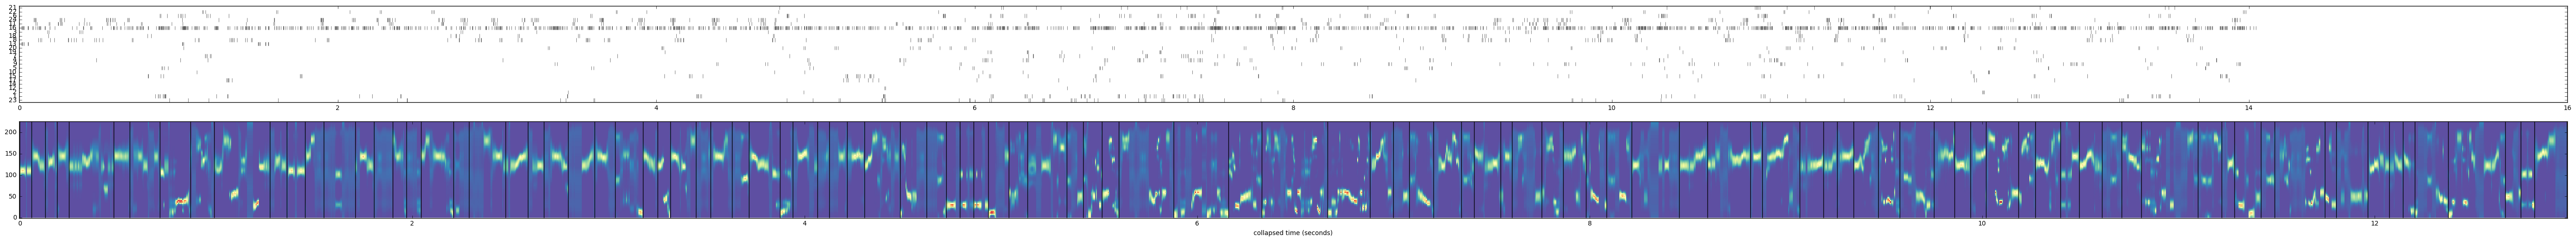

In [120]:
# decode neural activity
ds_5ms = 0.005
bst = muaspks._bin(ds=ds_5ms) # no spike smoothing this time
posteriors, bdries, mode_pth, mean_pth = decode(bst, smoothed_rate, w=4)

fig = plt.figure(figsize=(72,6))
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)

npl.rasterplot(collapse_time(muaspks), ax=ax0, lw=0.5, vertstack=True)
ax1.vlines(bdries*ds_5ms, 0, 225)
npl.imagesc(x=np.linspace(0,ds_5ms*posteriors.shape[1],3000), y=np.linspace(0,225,1000), data=posteriors, cmap=plt.cm.Spectral_r, ax=ax1)
ax1.set_xlabel('collapsed time (seconds)')

# ax1 = fig.add_subplot(212)
# ax1.plot(mode_pth, label='mode path', alpha=0.2)
# ax1.plot(mean_pth, label='expected path')
# ax1.vlines(np.cumsum(bst.lengths), xmin, xmax)

# npl.utils.clear_left_right(ax0)
# npl.utils.clear_top_bottom(ax0)

# ax1.legend()

axes=[ax0, ax1]

# for ax in axes:
#     ax.set_xlim([0,500])


In [48]:
mapmat = np.zeros_like(posteriors)
for t in range(posteriors.shape[1]):
    r = np.argmax(posteriors[:,t])
    mapmat[r,t] = posteriors[r,t]
    

In [ ]:
npl.rasterplot(st, vertstack=True)

In [ ]:
npl.rasterplot(st, vertstack=False)

### Look more carefully at mua and spike rasters

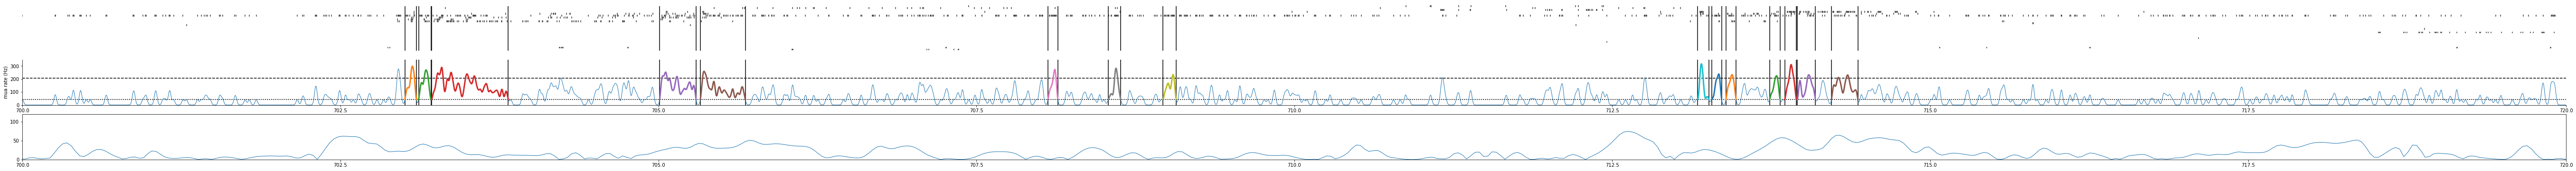

In [59]:
fig = plt.figure(figsize=(96,6))

ax0 = fig.add_subplot(311)
ax1 = fig.add_subplot(312)
ax2 = fig.add_subplot(313)

npl.plot(speed1, ax=ax2, lw=1)
npl.plot(mua, ax=ax1, lw=1)
npl.plot(mua[mua_epochs1], ax=ax1, lw=3)

Pthresh1 = mua[0].mean() + 3*mua[0].std()
Pmean1 = mua[0].mean()

# ax1.set_xlim(867,873)

# npl.rasterplot(st[nel.EpochArray([1042,1048], fs=1)], ax=ax0)
npl.rasterplot(st, ax=ax0, vertstack=True)

npl.utils.clear_left_right(ax0)
npl.utils.clear_top(ax1)
npl.utils.clear_right(ax1)
npl.utils.clear_top_bottom(ax0)

ax1.set_xlabel('times (s)')
ax1.set_ylabel('mua rate (Hz)')
ax1.set_ylim(0,350)
ax2.set_ylim(0,120)

ax0.vlines(mua_epochs1.time.flatten(), 0, st.n_units)
ax1.vlines(mua_epochs1.time.flatten(), 0, 1000)
ax1.hlines(Pthresh1, 0, 1500, linestyles='--')
ax1.hlines(Pmean1, 0, 1500, linestyles=':')

# npl.utils.set_xlim((1042,1048), ax0, ax1)
npl.utils.set_xlim((700,720), ax0, ax1, ax2)

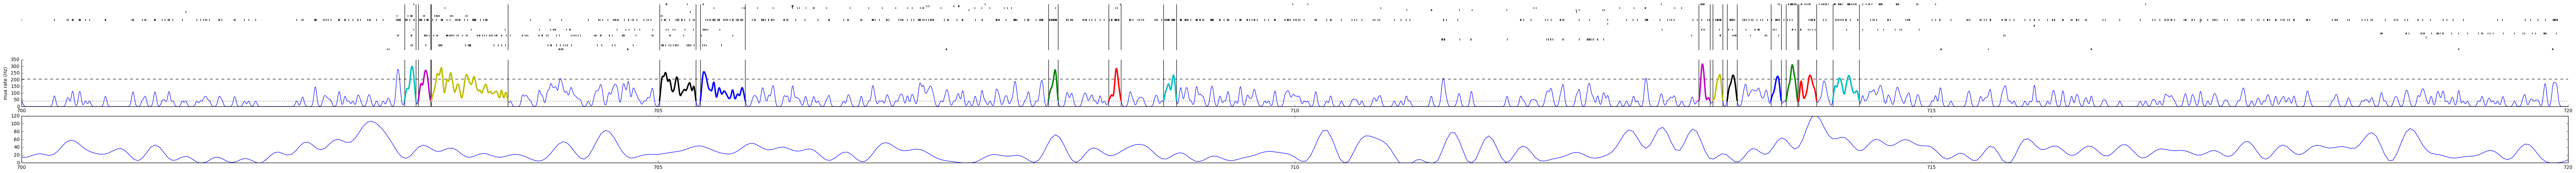

In [133]:
fig = plt.figure(figsize=(96,6))

ax0 = fig.add_subplot(311)
ax1 = fig.add_subplot(312)
ax2 = fig.add_subplot(313)

npl.plot(speed1, ax=ax2, lw=1)
npl.plot(mua, ax=ax1, lw=1)
npl.plot(mua[mua_epochs1], ax=ax1, lw=3)

Pthresh1 = mua[0].mean() + 3*mua[0].std()
Pmean1 = mua[0].mean()

# ax1.set_xlim(867,873)

# npl.rasterplot(st[nel.EpochArray([1042,1048], fs=1)], ax=ax0)
npl.rasterplot(st, ax=ax0, vertstack=False)

npl.utils.clear_left_right(ax0)
npl.utils.clear_top(ax1)
npl.utils.clear_right(ax1)
npl.utils.clear_top_bottom(ax0)

ax1.set_xlabel('times (s)')
ax1.set_ylabel('mua rate (Hz)')
ax1.set_ylim(0,350)
ax2.set_ylim(0,120)

ax0.vlines(mua_epochs1.time.flatten(), 0, st.n_units)
ax1.vlines(mua_epochs1.time.flatten(), 0, 1000)
ax1.hlines(Pthresh1, 0, 1500, linestyles='--')
ax1.hlines(Pmean1, 0, 1500, linestyles=':')

# npl.utils.set_xlim((1042,1048), ax0, ax1)
npl.utils.set_xlim((700,720), ax0, ax1, ax2)